In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as opt
from tqdm import tqdm_notebook

In [3]:
device = torch.device('cuda:0')
print(device)

cuda:0


In [0]:
transform_train = transforms.Compose(
    [transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size = 4
no_classes = 10

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [8]:
dataiter = iter(trainloader)

inputs, labels = dataiter.next()
print(inputs.shape)
print(inputs[0].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
7


In [0]:
def imageshow(img, title):
  img = img.numpy() /2 + 0.5
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.title(title)  
  plt.show()

In [0]:
def show_batches(dataloader):
  img, labels = next(iter(dataloader))
  image = torchvision.utils.make_grid(img)
  imageshow(image, [str(x.item()) for x in labels])

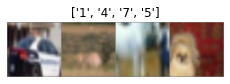

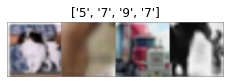

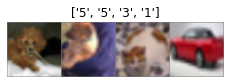

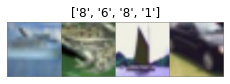

In [11]:
for i in range(4):
  show_batches(trainloader)

In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn()

In [14]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
print(vgg.features[5])

ReLU(inplace=True)


In [16]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [17]:
final_in_feature = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_feature, no_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [18]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100*correct / total

In [0]:
vgg  = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = opt.Adam(vgg.parameters())

In [21]:
'''epochs = 1
loss_arr = []
train_iter = np.ceil(50000 / batch_size)
for epoch in range(epochs):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    output = vgg(inputs)
    loss = loss_fn(output, labels)
    loss.backward()
    opt.step()
  loss_arr.append(loss.item)
  del inputs, labels, output
  torch.cuda.empty_cache()
  if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, train_iter, loss.item()))

  print('train and test accuracy', evaluation(trainloader, vgg), evaluation(testloader, vgg))
plt.plot(loss_arr)
plt.show()'''

"epochs = 1\nloss_arr = []\ntrain_iter = np.ceil(50000 / batch_size)\nfor epoch in range(epochs):\n  for i, data in enumerate(trainloader, 0):\n    inputs, labels = data\n    inputs, labels = inputs.to(device), labels.to(device)\n    opt.zero_grad()\n    output = vgg(inputs)\n    loss = loss_fn(output, labels)\n    loss.backward()\n    opt.step()\n  loss_arr.append(loss.item)\n  del inputs, labels, output\n  torch.cuda.empty_cache()\n  if i % 100 == 0:\n            print('Iteration: %d/%d, Loss: %0.2f' % (i, train_iter, loss.item()))\n\n  print('train and test accuracy', evaluation(trainloader, vgg), evaluation(testloader, vgg))\nplt.plot(loss_arr)\nplt.show()"

In [0]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
vgg = models.vgg16_bn(pretrained=True)

In [0]:
for param in vgg.parameters():
  param.requires_grad = False

In [0]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, no_classes)

In [26]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [27]:
vgg  = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = opt.Adam(vgg.parameters())

AttributeError: ignored

In [0]:
'''epochs = 1
loss_arr = []
train_iter = np.ceil(50000 / batch_size)
for epoch in range(epochs):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    output = vgg(inputs)
    loss = loss_fn(output, labels)
    loss.backward()
    opt.step()
  loss_arr.append(loss.item)
  del inputs, labels, output
  torch.cuda.empty_cache()
  if i % 1 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, train_iter, loss.item()))

  print('train and test accuracy', evaluation(trainloader, vgg), evaluation(testloader, vgg))
plt.plot(loss_arr)
plt.show()'''

In [0]:
import copy

In [0]:
'''epochs = 1
min_loss = 100
loss_arr = []
train_iter = np.ceil(50000 / batch_size)
for epoch in range(epochs):
  inputs, labels = next(iter(trainloader))
  inputs, labels = inputs.to(device), labels.to(device)
  opt.zero_grad()
  output = vgg(inputs)
  loss = loss_fn(output, labels)
  loss.backward()
  opt.step()
  loss_arr.append(loss.item)
  del inputs, labels, output
  torch.cuda.empty_cache()
  if min_loss > loss.item():
    min_loss = loss.item()
    best_model = copy.deepcopy(vgg.state_dict())
    print(min_loss)
  if i % 1 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, train_iter, loss.item()))

  print('train and test accuracy', evaluation(trainloader, vgg), evaluation(testloader, vgg))
plt.plot(loss_arr)
plt.show()'''

In [29]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

NameError: ignored

In [0]:
resnet = models.resnet18(pretrained=True)

In [0]:
for param in resnet.parameters():
  param.requires_grad = False

In [32]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
last_in_feature = resnet.fc.in_features
resnet.fc = nn.Linear(last_in_feature, no_classes)

In [0]:
print(resnet.fc)

In [34]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [35]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = opt.Adam(resnet.parameters())

AttributeError: ignored

In [0]:
epochs = 1
min_loss = 100
loss_arr = []
no_iter = np.ceil(50000 / batch_size)
for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      opt.zero_grad()
      output = vgg(inputs)
      loss = loss_fn(output, labels)
      loss.backward()
      opt.step()
      
      if min_loss > loss.item():
        min_loss = loss.item()
        best_model = copy.deepcopy(vgg.state_dict())
        print(min_loss)
        
      if i % 100 == 0:
        print('Iteration: %d/%d, Loss: %0.2f' % (i, train_iter, loss.item()))
      
      del inputs, labels, output
      torch.cuda.empty_cache()
      
    loss_arr.append(loss.item)
    print('train and test accuracy', evaluation(trainloader, vgg), evaluation(testloader, vgg))
plt.plot(loss_arr)
plt.show()

In [39]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [0]:
for param in inception.parameters():
  param.requires_grad=False

In [42]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc  = nn.Linear(aux_in_features, no_classes)

In [44]:
for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [0]:
in_feature = inception.fc.in_features
inception.fc = nn.Linear(in_feature, no_classes)

In [47]:
for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [0]:
transform_train = transforms.Compose(
    [transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

In [49]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
def evaluation_mod(dataloader, model):
  correct, total = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    output, aux_output = model(inputs)
    _, pred= torch.max(output.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    return 100*correct/total

In [0]:
inception = inception.to(device)
opt = opt.Adam(inception.parameters())
loss_fn = nn.CrossEntropyLoss()

In [54]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

Min loss 3.17
Iteration: 0/12500, Loss: 3.17
Min loss 2.25
Min loss 1.94
Iteration: 100/12500, Loss: 2.95
Min loss 1.76
Iteration: 200/12500, Loss: 3.15
Min loss 1.55
Iteration: 300/12500, Loss: 3.55
Min loss 1.50
Iteration: 400/12500, Loss: 3.21
Min loss 1.38
Min loss 1.36
Min loss 1.29
Iteration: 500/12500, Loss: 2.70
Iteration: 600/12500, Loss: 2.09
Min loss 1.16
Min loss 1.12
Iteration: 700/12500, Loss: 3.57
Iteration: 800/12500, Loss: 3.73
Min loss 1.11
Iteration: 900/12500, Loss: 2.72
Min loss 1.10
Min loss 1.06
Iteration: 1000/12500, Loss: 2.90
Iteration: 1100/12500, Loss: 2.07
Min loss 0.92
Iteration: 1200/12500, Loss: 2.82
Iteration: 1300/12500, Loss: 3.71
Min loss 0.86
Iteration: 1400/12500, Loss: 3.24
Iteration: 1500/12500, Loss: 1.81
Min loss 0.62
Iteration: 1600/12500, Loss: 2.85
Iteration: 1700/12500, Loss: 2.52
Iteration: 1800/12500, Loss: 1.95
Iteration: 1900/12500, Loss: 2.37
Iteration: 2000/12500, Loss: 3.02
Iteration: 2100/12500, Loss: 2.28
Iteration: 2200/12500, Los

NameError: ignored

In [66]:
inception.load_state_dict(best_model)
print(evaluation_mod(trainloader, inception), evaluation(testloader, inception))

TypeError: ignored